# EE5907/EE5027 CA1
Author: Liu Weihao

Date: 20 Sep
### Part I: MAP
#### Q1,Q2,Q3

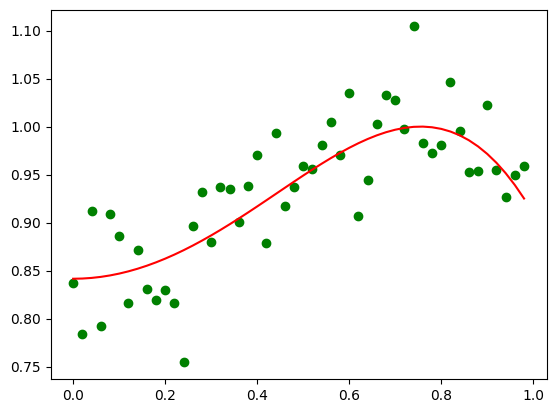

In [9]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# beta = sigma^(-2)
SIGMA = 0.04
BETA = SIGMA ** (-2)

# Generate 50 2D-data points
x = np.arange(0,1,0.02)
y = np.sin(np.power(x,2) + 1)

# Add gaussian noise. 0-mean, standard deiation:sigma=0.2
noise = np.random.normal(0,SIGMA,size=(50))
y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q4: Fit the noisy data using the MAP
$$
\bar{W}=(\mathbb{X}^T\mathbb{X}+\frac{\alpha}{\beta}I)^{-1}\mathbb{X}^T\bar{t}
$$
Where $\bar{W}$ is what we want. $\mathbb{X}$ is a $N\times M$ matrix, $t$ is a $N\times 1$ matrix.
$$
\mathbb{X}=\left(\begin{array}{cc} 
x_0^0&x_0^1&\ldots&x_0^{M-1}\\
x_1^0&x_1^1&\ldots&x_1^{M-1}\\
\vdots & \vdots & \ddots & \vdots\\
x_{N-1}^0&x_{N-1}^1&\ldots&x_{N-1}^{M-1}
\end{array}\right)
$$
$$
\bar{t}=y=\left(\begin{array}{cc}
y_0\\y_1\\\vdots\\ y_{N-1}
\end{array}\right)
$$
In our case, $y$ is $t$. $\alpha$ is standard deiation of $w$, $\beta$ is standard deiation of $\bar{w}^T\bar{x}_n$($\bar{t}$).

In [10]:
# Global parameter M and N. Let alpha = 0.05
LEN_M = 4
LEN_N = len(x)
ALPHA = 0.2
# Generate X and t
x_m = np.array([np.power(x,i) for i in range(LEN_M)]).reshape(LEN_M,LEN_N).T
t = y_noisy.reshape(LEN_N,1)
print(f'The shape of X is:{x_m.shape}\nThe shape of t is:{t.shape}')

The shape of X is:(50, 4)
The shape of t is:(50, 1)


In [11]:
# Get W
tmp_w = np.linalg.inv((np.dot(x_m.T,x_m)+(ALPHA/BETA)*np.identity(LEN_M)))
w = np.dot(np.dot(tmp_w,x_m.T),t)
w.shape


(4, 1)

#### Q5: Compute and display the total absolute error value (between the predicted and the correct ones) of using the computed w.

In [12]:
# Get estimated values
y_est = np.dot(x_m,w)
# Calculate the absolute error value
abs_error = np.sum(np.abs(y.reshape(50,1)-y_est))
abs_error

0.3323558261627281

#### Q6: Display the estimated values of w

In [13]:
w

array([[ 0.83883274],
       [-0.10200828],
       [ 1.18920658],
       [-1.00604216]])

#### Q7
$M$ and $\alpha$ are hyper parameters. We can use hyperopt and tpe algorithm to find the best one. In this CA, we only need to try 5-10 different parameters.


##### Basic requirment. Try 10 different parameters.

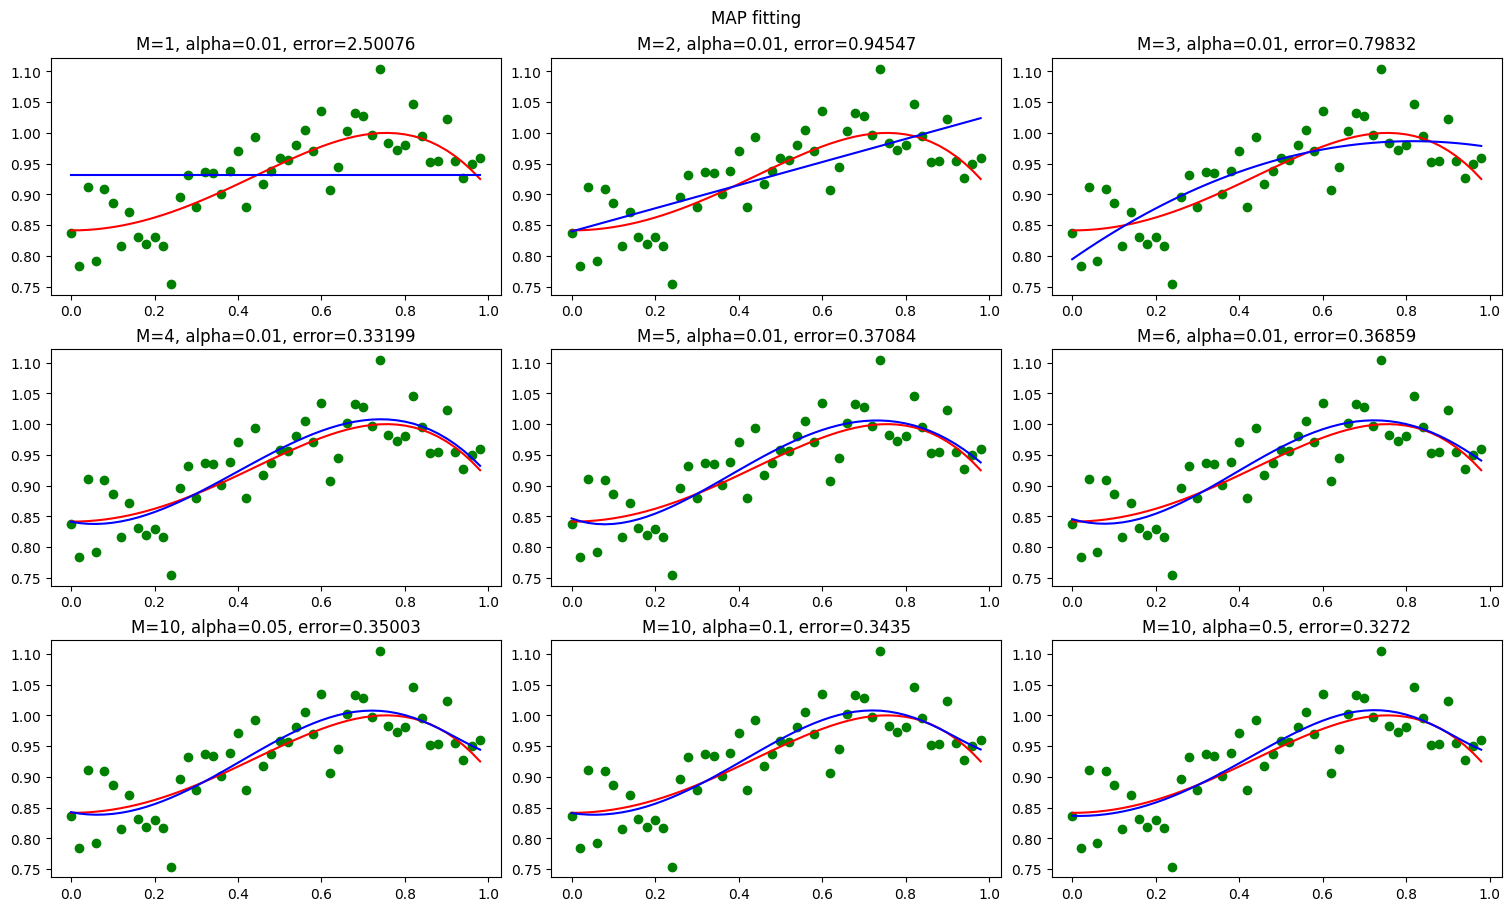

In [14]:
# define the MAP calculation function
def MAP_fitting(x:np.ndarray, y_noisy:np.ndarray, alpha:float, m:int)->np.ndarray:
    n = len(x)
    # Generate X and t
    mx = np.array([np.power(x,i) for i in range(m)]).reshape(m,n).T
    t = y_noisy.reshape(n,1)
    # Calculate W
    tmp_w = np.linalg.inv((np.dot(mx.T,mx)+(alpha/BETA)*np.identity(m)))
    MAP_w = np.dot(np.dot(tmp_w,mx.T),t)
    # Return back the parameter w
    return MAP_w

# Calculate the absolute error
def MAP_error(w:np.ndarray, x:np.ndarray, y:np.ndarray) -> tuple[float, np.ndarray]:
    m = len(w)
    n = len(x)
    # Generate X
    mx = np.array([np.power(x,i) for i in range(m)]).reshape(m,n).T
    # Estimate y
    y_est = np.dot(mx,w)
    # return the error
    return float(np.sum(np.abs(y.reshape(n,1)-y_est))), y_est

# x is our time series, y is the original data, y_noisy is the noisy data
def MAP_plt(x:np.ndarray, y:np.ndarray,y_noisy:np.ndarray, m_list:list, alpha_list:list):
    row_num = math.ceil(len(m_list)/3)
    col_num = 3
    fig, axs = plt.subplots(row_num,col_num, figsize=(15,9), constrained_layout=True)
    for ax, m, alpha in zip(axs.flatten(), m_list, alpha_list):
        # Calculate result
        MAP_w = MAP_fitting(x, y_noisy, alpha, m)
        error, y_est = MAP_error(MAP_w, x, y)
        ax.set_title(f'M={m}, alpha={alpha}, error={round(error,5)}')
        # plot function
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, y_est, 'b-')
    fig.suptitle('MAP fitting')

m_list= [1,2,3,\
         4,5,6,\
         10,10,10]
alpha_list = [0.01, 0.01, 0.01, \
              0.01, 0.01, 0.01, \
              0.05, 0.1, 0.5]
MAP_plt(x,y,y_noisy,m_list,alpha_list)


#### Q8 Discuss how M and alpha influence on the fitting accuracy.
Try 1000 different parameters, plot the 3D plot

100%|██████████| 1000/1000 [00:18<00:00, 53.09trial/s, best loss: 0.31490573360731444]


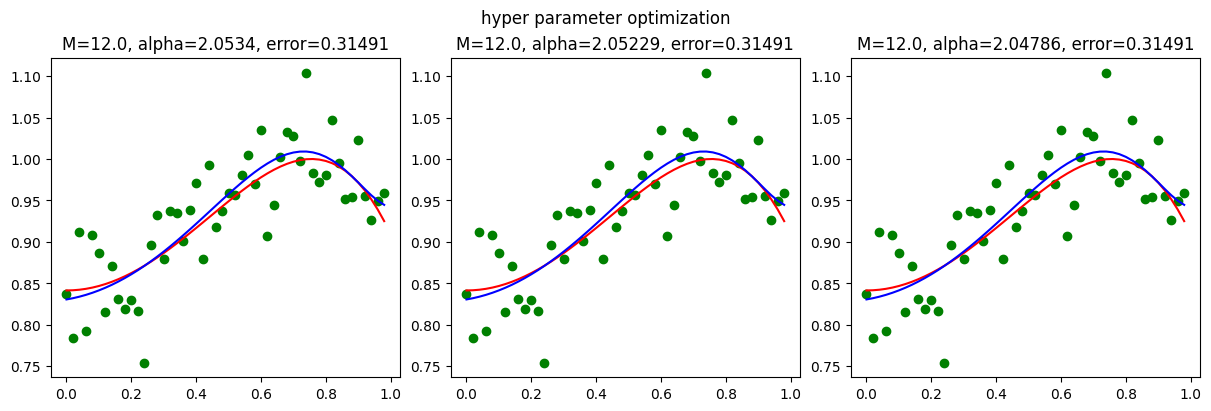

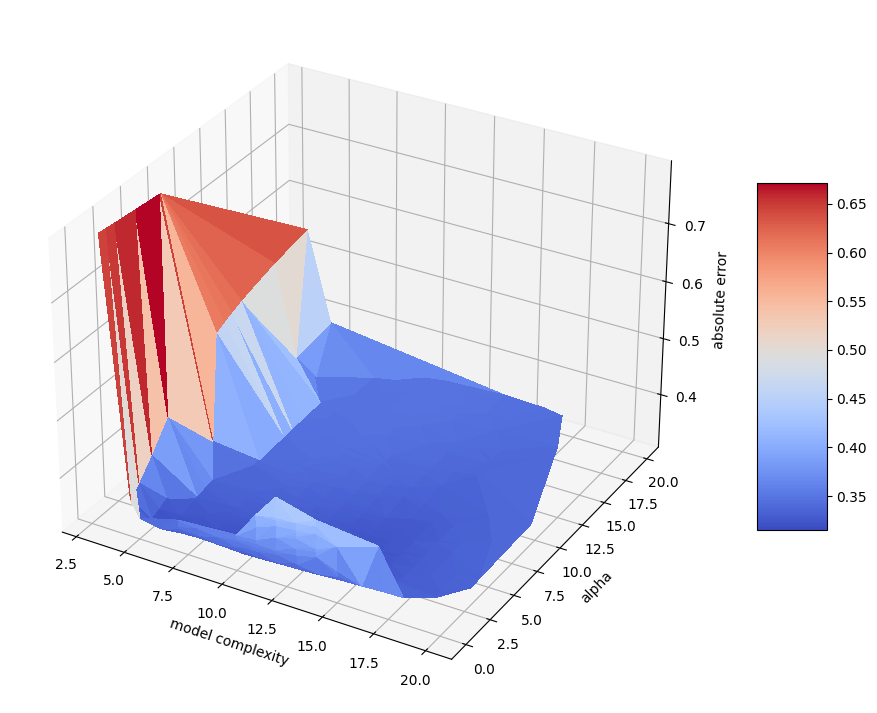

In [15]:
# Hyper parameter optimization. TPE algorithm
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
# The hyperparameter space
space = {
    'model_complexity': hp.quniform('model_complexity',3,20,1), # model_complexity is an integer. range: [3,20]
    'alpha': hp.uniform('alpha', 0.0001,20)                       # alpha is a float number, range: [0.0001,10]
}

# Create a optimization function. Input our data
def get_objective(x:np.ndarray,y:np.ndarray, y_noisy:np.ndarray):
    # params is our hyper parameter
    def objective(params:dict):
        m = int(params['model_complexity'])
        n = len(x)
        # Data processing
        mx = np.array([np.power(x,i) for i in range(m)]).reshape(m,n).T
        t = y_noisy.reshape(n,1)
        # Calculate W
        tmp_w = np.linalg.inv((np.dot(mx.T,mx)+(params['alpha']/BETA)*np.identity(m)))
        w = np.dot(np.dot(tmp_w,mx.T),t)
        # Calculate absolute error
        y_est = np.dot(mx,w)
        error = float(np.sum(np.abs(y.reshape(n,1)-y_est)))
        objective.i += 1
        return {'loss':error, 'status':STATUS_OK, 'params':params, 'y_estimation':y_est}
    return objective

# Call the hyperparameter optimization function, and deal with the resuls
# Plot best 3 results. Default try 100 parameters
def hyper_opt(x:np.ndarray, y:np.ndarray, y_noisy, num_trails:int=100):
    trails = Trials()
    objective = get_objective(x, y, y_noisy)
    objective.i = 0
    best = fmin(
        fn=objective,
        space = space,
        algo = tpe.suggest,
        max_evals = num_trails,
        trials= trails
    )
    # Get best 3 results
    hyper_opt_results = np.array(trails.trials)
    error_list = np.array([hyper_opt_results[i]['result']['loss'] for i in range(num_trails)])
    result_argsort = np.argsort(error_list)
    best_results = hyper_opt_results[result_argsort[0:3]]

    # plot the best 3 results
    fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
    for ax, iter_trail in zip(axs.flatten(), best_results):
        param = iter_trail['result']['params']
        ax.set_title('M={}, alpha={}, error={}'.format(param['model_complexity'], round(param['alpha'],5), round(iter_trail['result']['loss'],5)))
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, iter_trail['result']['y_estimation'], 'b-')
    fig.suptitle('hyper parameter optimization')

    # plot the 3D graph. We can see the influence of M and alpha
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    # Get all parameters and error
    model_complexity_list = np.array([hyper_opt_results[i]['result']['params']['model_complexity'] for i in range(num_trails)])
    param_alpha_list = np.array([hyper_opt_results[i]['result']['params']['alpha'] for i in range(num_trails)])
    # plot the surface
    surf = ax.plot_trisurf(model_complexity_list, param_alpha_list, error_list, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("alpha")
    ax.set_zlabel("absolute error")
    

# Try 1000 different parameters, find the best
hyper_opt(x, y, y_noisy,1000)

### Part II: Basis Function
#### Q1, Q2 Generate dataset (same as part I)

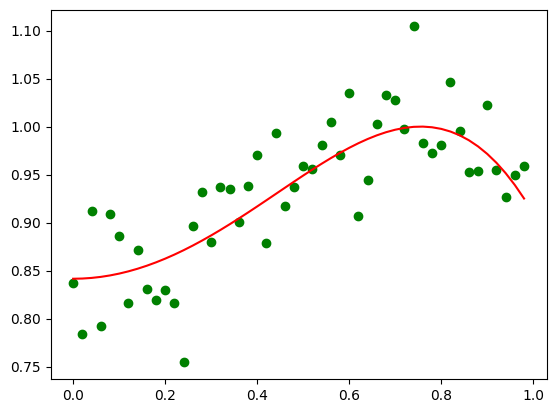

In [17]:
# Use Part I dataset, so that we can compare MAP and MLE
# # beta = sigma^(-2)
# SIGMA = 0.2
# BETA = SIGMA ** (-2)

# # Generate 50 2D-data points
# x = np.arange(0,1,0.02)
# y = np.sin(np.power(x,2) + 1)

# # Add gaussian noise. 0-mean, standard deiation:sigma=0.15
# noise = np.random.normal(0,SIGMA**2,size=(50))
# y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q3: Fit the generated noisy data using the MLE that employs the Gaussian basis functions
$$
\bar{w}=(\Phi^T\Phi)^{-1}\Phi^T\bar{t}
$$
Where:$\Phi$ is a N by M matrix
$$
\Phi=\left(\begin{array}{cc} 
\phi_0(x_0)&\phi_1(x_0)&\ldots&\phi_{M-1}(x_0)\\
\phi_0(x_1)&\phi_1(x_1)&\ldots&\phi_{M-1}(x_1)\\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(x_{N-1})&\phi_1(x_{N-1})&\ldots&\phi_{M-1}(x_{N-1})\\
\end{array}\right)
$$
Besides, We want to apply Gaussian basis function:
$$
\phi_m(x_n)=exp(-\frac{(x_n-\mu_m)^2}{2s^2})
$$
In my program, the mean $\mu_m$ is uniform distribution on $[0,1]$. $s=\frac{1}{M}$

In [18]:
def gaussian_basis(x:np.ndarray, mu:float, s:float=1):
    return np.exp(- np.linalg.norm(x-mu)**2 / (2 * s**2))

def MLE_basis(x:np.ndarray, y_noisy:np.ndarray, model_m:int) -> tuple[np.ndarray, np.ndarray]:
    # Create an empty matrix
    Phi = np.ones((LEN_N, model_m))
    sigma = 1/model_m
    # First column is 1. other column apply gaussian basis function
    for m in range(1,model_m):
        mu = m/model_m
        Phi[:,m] = np.vectorize(gaussian_basis)(x, mu, sigma)

    #Apply the above formular
    t = y_noisy.reshape(LEN_N,1)
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t
    return w, Phi
tmp_w, tmp_Phi = MLE_basis(x, y_noisy, 4)
tmp_w

array([[ 0.86020342],
       [-0.04622924],
       [ 0.06189241],
       [ 0.11392173]])

#### Q4: For underfitting, we use M=3. For overfitting, M=20

Text(0.5, 0.98, 'hyper parameter optimization')

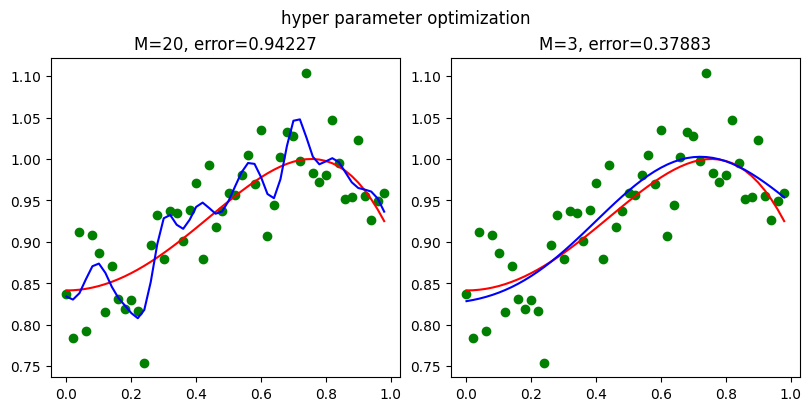

In [19]:
# estimate the y
def basis_error(phi:np.ndarray, w:np.ndarray, y:np.ndarray) -> tuple[float, np.ndarray]:
    y_est = phi @ w
    # return the error
    return float(np.sum(np.abs(y.reshape(LEN_N,1)-y_est))), y_est

# Calculate the w
w_p2 = []
Phi = []
tmp_result = MLE_basis(x, y_noisy, 20)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])
tmp_result = MLE_basis(x, y_noisy, 3)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])

# Plot the result
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
for ax, tmp_w, tmp_phi in zip(axs.flatten(),w_p2, Phi):
    error, y_est = basis_error(tmp_phi, tmp_w, y)
    ax.set_title(f'M={len(tmp_w)}, error={round(error,5)}')
    ax.plot(x, y, 'r-')
    ax.scatter(x, y_noisy,color='green')
    ax.plot(x, y_est, 'b-')
fig.suptitle('hyper parameter optimization') 

#### Q5: Change the basis function to the sigmoid basis function
The sigmoid basis function can be expressed as:
$$
\phi_m(x_n)=\sigma(\frac{x_n-\mu_m}{s})=\frac{1}{1+exp(-\frac{x_n-\mu_m}{s})}
$$

Text(0.5, 0.98, 'hyper parameter optimization')

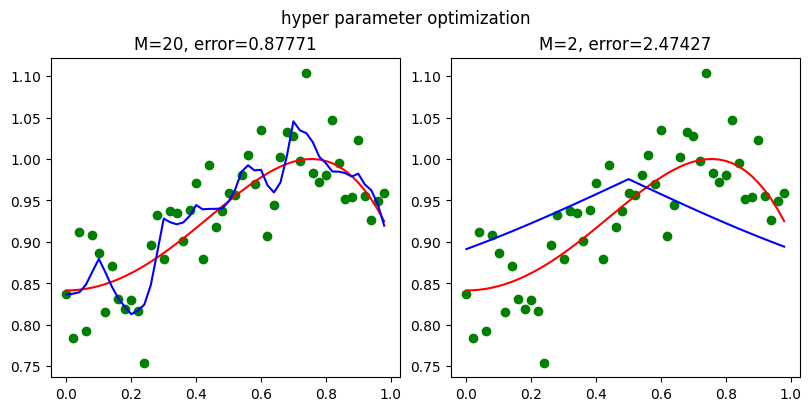

In [37]:
def sigmoid_basis(x:np.ndarray, mu:float, s:float=1):
    return 1 / (1 + np.exp(- np.linalg.norm(x-mu) / s))

def MLE_sigmoid_basis(x:np.ndarray, y_noisy:np.ndarray, model_m:int) -> tuple[np.ndarray, np.ndarray]:
    # Create an empty matrix
    Phi = np.ones((LEN_N, model_m))
    sigma = 1/model_m
    # First column is 1. other column apply gaussian basis function
    for m in range(1,model_m):
        mu = m/model_m
        Phi[:,m] = np.vectorize(sigmoid_basis)(x, mu, sigma)

    #Apply the above formular
    t = y_noisy.reshape(LEN_N,1)
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t
    return w, Phi
tmp_w, tmp_Phi = MLE_basis(x, y_noisy, 4)

# Calculate the w
w_p2 = []
Phi = []
tmp_result = MLE_sigmoid_basis(x, y_noisy, 20)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])
tmp_result = MLE_sigmoid_basis(x, y_noisy, 2)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])

# Plot the result
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
for ax, tmp_w, tmp_phi in zip(axs.flatten(),w_p2, Phi):
    error, y_est = basis_error(tmp_phi, tmp_w, y)
    ax.set_title(f'M={len(tmp_w)}, error={round(error,5)}')
    ax.plot(x, y, 'r-')
    ax.scatter(x, y_noisy,color='green')
    ax.plot(x, y_est, 'b-')
fig.suptitle('hyper parameter optimization')

#### Q6: Chang the original cureve function to $y=0.4345x^3-5.607x^2+16.78x-10.61$
Use the sigmoid function to estimate the best curve fitting from noisy data.
In my program. I use `hyperopt` to find the best parameter. $M$ and $s$ is the hyper parameter.

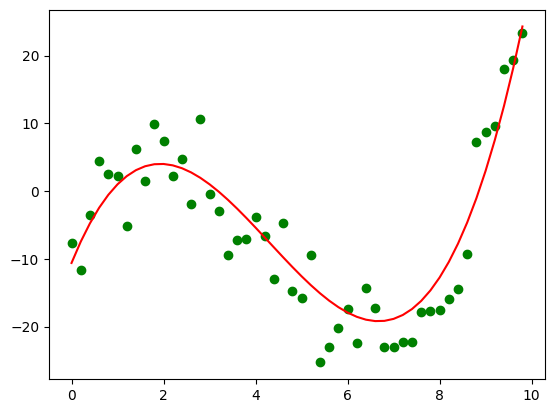

In [29]:
# Generate new dataset
x_p2 = np.arange(0,10,0.2)
y_p2 = 0.4345*np.power(x_p2,3)-5.607*np.power(x_p2,2)+16.78*x_p2-10.61
# Gausion noise, sigma = 5
noise = np.random.normal(0,5,size=(50))
y_noisy_p2 = y_p2 + noise
plt.plot(x_p2,y_p2,'r-')
plt.scatter(x_p2,y_noisy_p2,color='green')
plt.show()

100%|██████████| 3000/3000 [02:39<00:00, 18.79trial/s, best loss: 129.31155993500218]


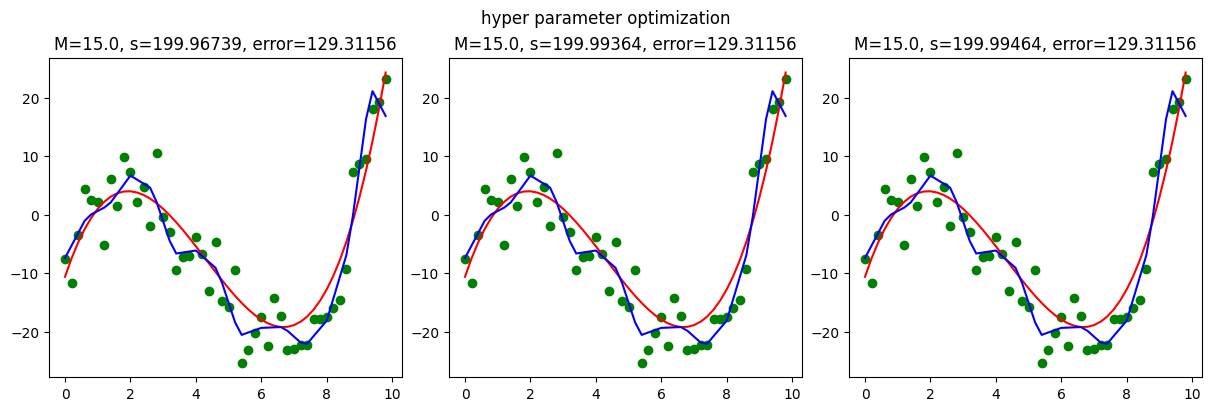

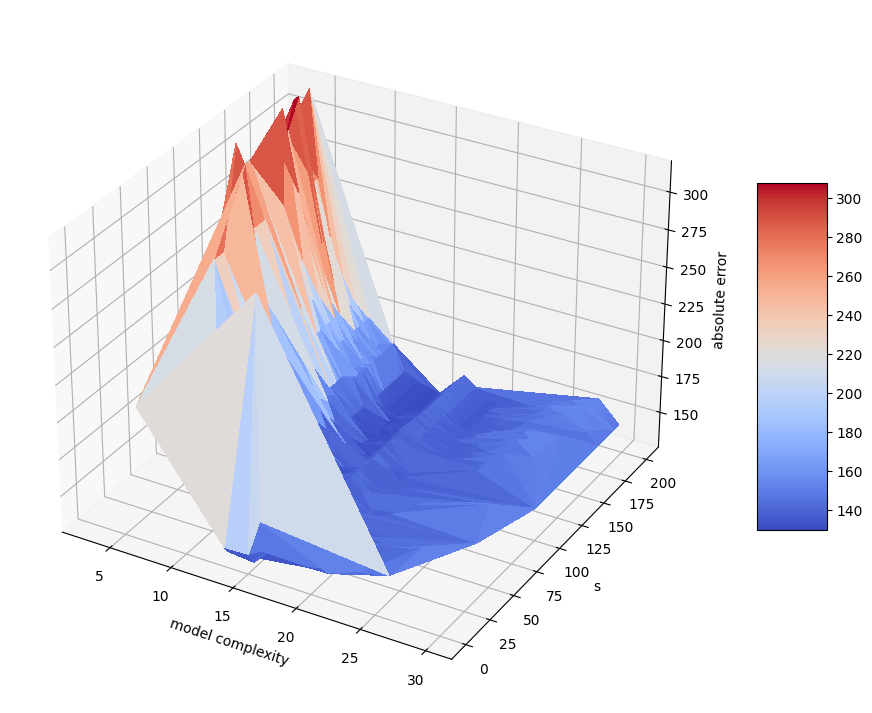

In [58]:
# The hyperparameter space
space_p2 = {
        'model_complexity': hp.quniform('model_complexity',3,30,1), # model_complexity is an integer. range: [3,20]
        's': hp.uniform('s', 0.00001,200)                       # alpha is a float number, range: [0.0001,10]
}

# Create a optimization function. Input our data
def get_p2_objective(x:np.ndarray,y:np.ndarray, y_noisy:np.ndarray):
    # params is our hyper parameter
    def objective(params:dict):
        m = int(params['model_complexity'])
        n = len(x)
        # Data processing
        Phi = np.ones((n, m))
        sigma = params['s']
        # First column is 1. other column apply gaussian basis function
        for i in range(1,m):
            mu = 10*i/m
            Phi[:,i] = np.vectorize(sigmoid_basis)(x, mu, sigma)

        # Calculate W
        t = y_noisy.reshape(LEN_N,1)
        w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t

        # Calculate absolute error
        error, y_est = basis_error(Phi, w, y)
        objective.i += 1
        return {'loss':error, 'status':STATUS_OK, 'params':params, 'y_estimation':y_est}
    return objective

# Call the hyperparameter optimization function, and deal with the resuls
# Plot best 3 results. Default try 100 parameters
def hyper_opt_p2(x:np.ndarray, y:np.ndarray, y_noisy, num_trails:int=100):
    trails = Trials()
    objective = get_p2_objective(x, y, y_noisy)
    objective.i = 0
    best = fmin(
        fn=objective,
        space = space_p2,
        algo = tpe.suggest,
        max_evals = num_trails,
        trials= trails
    )
    # Get best 3 results
    hyper_opt_results = np.array(trails.trials)
    error_list = np.array([hyper_opt_results[i]['result']['loss'] for i in range(num_trails)])
    result_argsort = np.argsort(error_list)
    best_results = hyper_opt_results[result_argsort[0:3]]

    # plot the best 3 results
    fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
    for ax, iter_trail in zip(axs.flatten(), best_results):
        param = iter_trail['result']['params']
        ax.set_title('M={}, s={}, error={}'.format(param['model_complexity'], round(param['s'],5), round(iter_trail['result']['loss'],5)))
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, iter_trail['result']['y_estimation'], 'b-')
    fig.suptitle('hyper parameter optimization')

    # plot the 3D graph. We can see the influence of M and alpha
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    # Get all parameters and error
    model_complexity_list = np.array([hyper_opt_results[i]['result']['params']['model_complexity'] for i in range(num_trails)])
    param_alpha_list = np.array([hyper_opt_results[i]['result']['params']['s'] for i in range(num_trails)])
    # plot the surface
    surf = ax.plot_trisurf(model_complexity_list, param_alpha_list, error_list, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("s")
    ax.set_zlabel("absolute error")
    

# Try 3000 different parameters, find the best 3 results
hyper_opt_p2(x_p2, y_p2, y_noisy_p2,3000)

#### Q7: Experiment with different parameters of the Gaussian and sigmoid basis functions.
The sigmoid result is shown as above graph. Next, I will try to find the best model from Gaussian basis function.

100%|██████████| 3000/3000 [02:36<00:00, 19.17trial/s, best loss: 49.945834388290855]


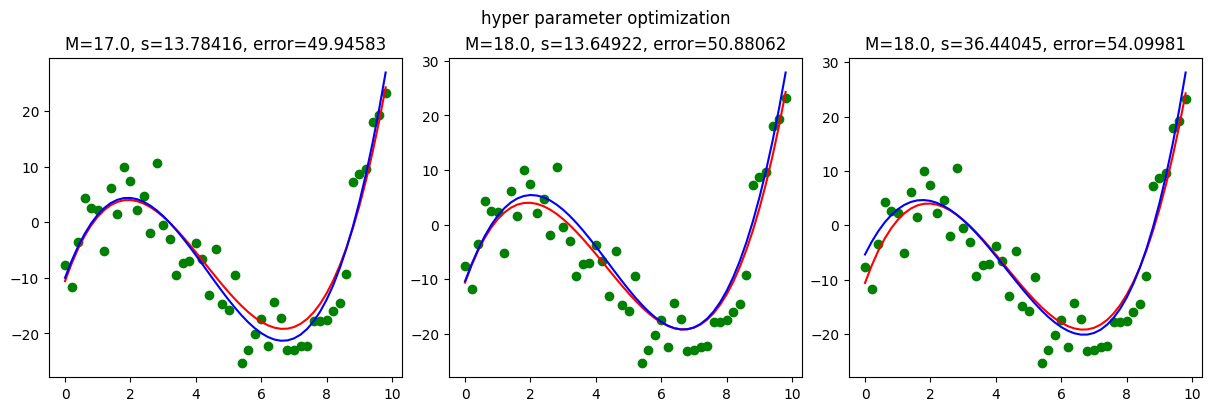

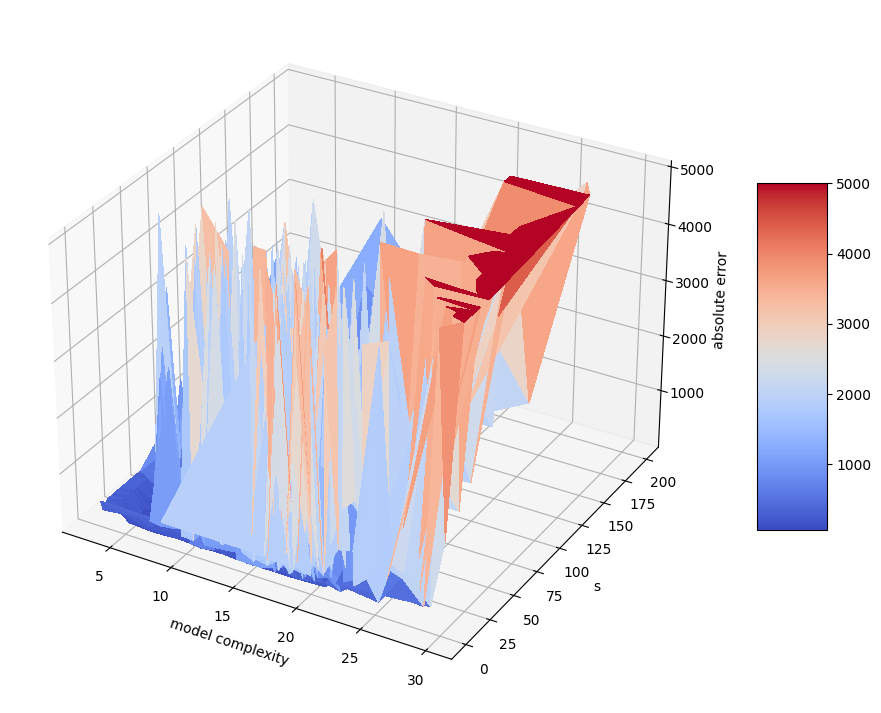

In [68]:
# The hyperparameter space
space_p2_gau = {
                'model_complexity': hp.quniform('model_complexity',3,30,1), # model_complexity is an integer. range: [3,20]
                's': hp.uniform('s', 0.00001,200)                       # alpha is a float number, range: [0.0001,10]
}

# Create a optimization function. Input our data
def get_p2_gau_objective(x:np.ndarray,y:np.ndarray, y_noisy:np.ndarray):
    # params is our hyper parameter
    def objective(params:dict):
        m = int(params['model_complexity'])
        n = len(x)
        # Data processing
        Phi = np.ones((n, m))
        sigma = params['s']
        # First column is 1. other column apply gaussian basis function
        for i in range(1,m):
            mu = 10*i/m
            Phi[:,i] = np.vectorize(gaussian_basis)(x, mu, sigma)

        # Calculate W
        t = y_noisy.reshape(LEN_N,1)
        # Drop the singular result
        if np.linalg.det(Phi.T @ Phi)==0:
            return {'loss':5000, 'status':STATUS_OK, 'params':params, 'y_estimation':0}
        w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t
        # Calculate absolute error
        error, y_est = basis_error(Phi, w, y)
        # The upper bound of error is 5000
        error = 5000 if error > 5000 else error
        objective.i += 1
        return {'loss':error, 'status':STATUS_OK, 'params':params, 'y_estimation':y_est}
    return objective

# Call the hyperparameter optimization function, and deal with the resuls
# Plot best 3 results. Default try 100 parameters
def hyper_opt_gau_p2(x:np.ndarray, y:np.ndarray, y_noisy, num_trails:int=100):
    trails = Trials()
    objective = get_p2_gau_objective(x, y, y_noisy)
    objective.i = 0
    best = fmin(
        fn=objective,
        space = space_p2_gau,
        algo = tpe.suggest,
        max_evals = num_trails,
        trials= trails
    )
    # Get best 3 results
    hyper_opt_results = np.array(trails.trials)
    error_list = np.array([hyper_opt_results[i]['result']['loss'] for i in range(num_trails)])
    result_argsort = np.argsort(error_list)
    best_results = hyper_opt_results[result_argsort[0:3]]

    # plot the best 3 results
    fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
    for ax, iter_trail in zip(axs.flatten(), best_results):
        param = iter_trail['result']['params']
        ax.set_title('M={}, s={}, error={}'.format(param['model_complexity'], round(param['s'],5), round(iter_trail['result']['loss'],5)))
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, iter_trail['result']['y_estimation'], 'b-')
    fig.suptitle('hyper parameter optimization')

    # plot the 3D graph. We can see the influence of M and alpha
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    # Get all parameters and error
    model_complexity_list = np.array([hyper_opt_results[i]['result']['params']['model_complexity'] for i in range(num_trails)])
    param_alpha_list = np.array([hyper_opt_results[i]['result']['params']['s'] for i in range(num_trails)])
    # plot the surface
    surf = ax.plot_trisurf(model_complexity_list, param_alpha_list, error_list, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("s")
    ax.set_zlabel("absolute error")
    

# Try 3000 different parameters, find the best 3 results
hyper_opt_gau_p2(x_p2, y_p2, y_noisy_p2,3000)

### Part III: Full Bayseian + Predictive distribution
#### Q1. Generate dataset.(Same as Part I, II)

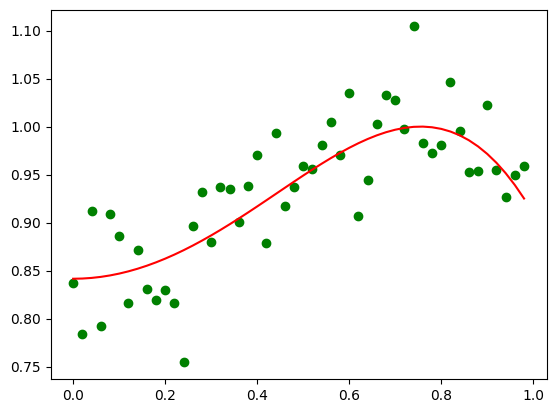

In [69]:
# Use Part I dataset, so that we can compare MAP and MLE
# # beta = sigma^(-2)
# SIGMA = 0.2
# BETA = SIGMA ** (-2)

# # Generate 50 2D-data points
# x = np.arange(0,1,0.02)
# y = np.sin(np.power(x,2) + 1)

# # Add gaussian noise. 0-mean, standard deiation:sigma=0.15
# noise = np.random.normal(0,SIGMA**2,size=(50))
# y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q2: Compute w based on the full Bayesian inference by using basis functions.
$$
\bar{w}_{full}=(\Phi^T\Phi+\frac{\alpha}{\beta}I)^{-1}\Phi^T\bar{t}
$$

In [71]:
# Let's apply Gaussian basis function
def Full_basis(x:np.ndarray, y_noisy:np.ndarray, model_m:int) -> tuple[np.ndarray, np.ndarray]:
    # Create an empty matrix
    Phi = np.ones((len(x), model_m))
    sigma = 1/model_m
    # First column is 1. other column apply gaussian basis function
    for m in range(1,model_m):
        mu = m/model_m
        Phi[:,m] = np.vectorize(gaussian_basis)(x, mu, sigma)

    #Apply the above formular
    t = y_noisy.reshape(len(x),1)
    w = np.linalg.inv(Phi.T @ Phi + (ALPHA/BETA)*np.identity(model_m)) @ Phi.T @ t
    return w, Phi
tmp_w, tmp_Phi = MLE_basis(x, y_noisy, 7)
tmp_w

array([[ 0.89120843],
       [-0.0433437 ],
       [-0.04661941],
       [ 0.11199621],
       [-0.06313153],
       [ 0.1273479 ],
       [ 0.02879801]])

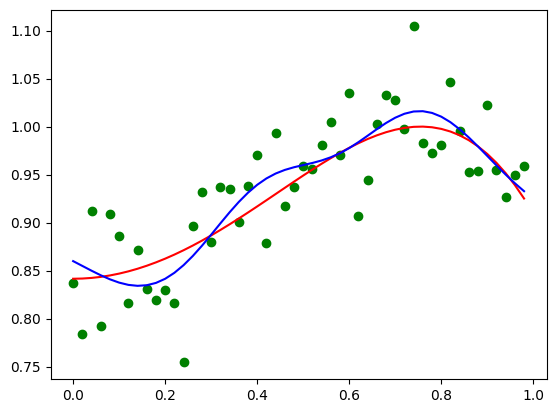

In [72]:
# Plot the result
error, y_est = basis_error(tmp_Phi, tmp_w, y)
plt.plot(x,y,'r-')
plt.plot(x,y_est,'b-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q3: Change alpha and beta.

In [ ]:
# 